# Learning GANs from Stochastic Partial Data
#### Dataset: CIFAR-10
#### GAN network: DCGAN (Deep Convolutional Generative Adversarial Network)
#### Approach: GAN training with real and noised images to model training data and achieve representative image generation. Uses MSE loss function.
### Training/testing sequence:
#### 1) Train network on dataset with known real and fake image labels
#### 2) Test network on original dataset and noised dataset
#### 3) Train new network on noised data with known real and fake image labels
#### 4) Test network on original dataset and noised dataset

In [ ]:
# Credit for referring to code from DCGAN tutorial on PyTorch website

In [ ]:
!pip install piq

     |████████████████████████████████| 127 kB 8.5 MB/s 


In [ ]:
import torch
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
import math

from torch import nn
from torch import optim

import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML

import torchvision.datasets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                               transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# # MNIST dataset
# dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
#                                transform=transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Pad(2),
#                                transforms.Normalize((0.5,), (0.5,)),
#                            ]))

# Size of training data reduced to allow for faster training
# Unperturbed data
set_fraction = (32000/len(dataset)) # get fraction of data to achieve dataset of 3200 images, which is 100 batches of 32 images/batch
# set_fraction = (16000/len(dataset)) # get fraction of data to achieve dataset of 3200 images, which is 100 batches of 32 images/batch
# set_fraction = (6400/len(dataset)) # get fraction of data to achieve dataset of 6400 images, which is 200 batches of 32 images/batch
# set_fraction = (4800/len(dataset)) # get fraction of data to achieve dataset of 4800 images, which is 150 batches of 32 images/batch
# set_fraction = (3200/len(dataset)) # get fraction of data to achieve dataset of 3200 images, which is 100 batches of 32 images/batch
# set_fraction = (1600/len(dataset)) # get fraction of data to achieve dataset of 1600 images, which is 50 batches of 32 images/batch
# set_fraction = (320/len(dataset)) # get fraction of data to achieve dataset of 320 images, which is 10 batches of 32 images/batch
# set_fraction = (96/len(dataset)) # get fraction of data to achieve dataset of 3 batches of 32 images/batch to speed up training
# set_fraction = (32/len(dataset)) # get fraction of data to achieve dataset of 1 batch of 32 images/batch to speed up training
dataset, testset, _ = torch.utils.data.dataset.random_split(dataset, [int(set_fraction*len(dataset)), int((1/2)*set_fraction*len(dataset)), int(len(dataset)-(3/2)*set_fraction*len(dataset))], generator=torch.Generator().manual_seed(42))

# Partial data to train GAN on for aim of project
class transformGaussianNoise():
    def __init__(self, mean=0, std=1):
        self.std = std
        self.mean = mean

    def __call__(self,tensor):
        return tensor + torch.randn(tensor.size())*self.std + self.mean

# Addition of Gaussian noise to image set
data_noise = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                               transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               transformGaussianNoise(0, 0.2)
                            ]))

# # MNIST dataset
# data_noise = torchvision.datasets.MNIST(root='./data', train=True, download=True,
#                                transform=transforms.Compose([
#                                transforms.ToTensor(),
#                                transforms.Pad(2),
#                                transforms.Normalize((0.5,), (0.5,)),
#                                transformGaussianNoise(0, 0.2)
#                             ]))

data_noise, testset_noise, _ = torch.utils.data.dataset.random_split(data_noise, [int(set_fraction*len(data_noise)), int((1/2)*set_fraction*len(data_noise)), int(len(data_noise)-(3/2)*set_fraction*len(data_noise))], generator=torch.Generator().manual_seed(42))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
# batch_size = 64
batch_size = 32
# batch_size = 128

# Spatial size of training images. All images will be resized to this
# size using a transformer.
# image_size = 64
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3
# nc = 1 # Change to 1 channel if running on MNIST dataset

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps for generator
# ngf = 64
ngf = 32

# Size of feature maps for discriminator
# ndf = 64
ndf = 32

# Number of training epochs
# num_epochs = 5
# num_epochs = 1
num_epochs = 10
# num_epochs = 20
# num_epochs = 50
# num_epochs = 100
# num_epochs = 150
# num_epochs = 200
# num_epochs = 500
# num_epochs = 1000
# num_epochs = 2000

# Learning rate for optimizers
lr = 0.0002
# lr = 0.0001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

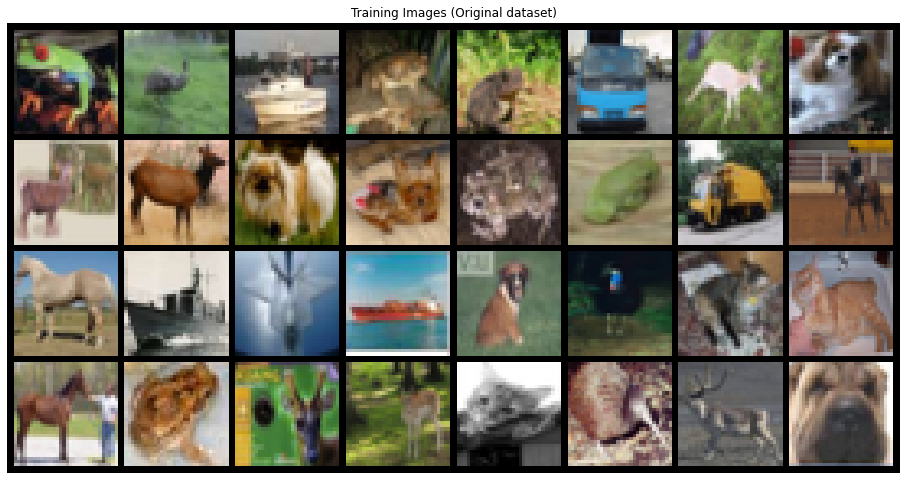

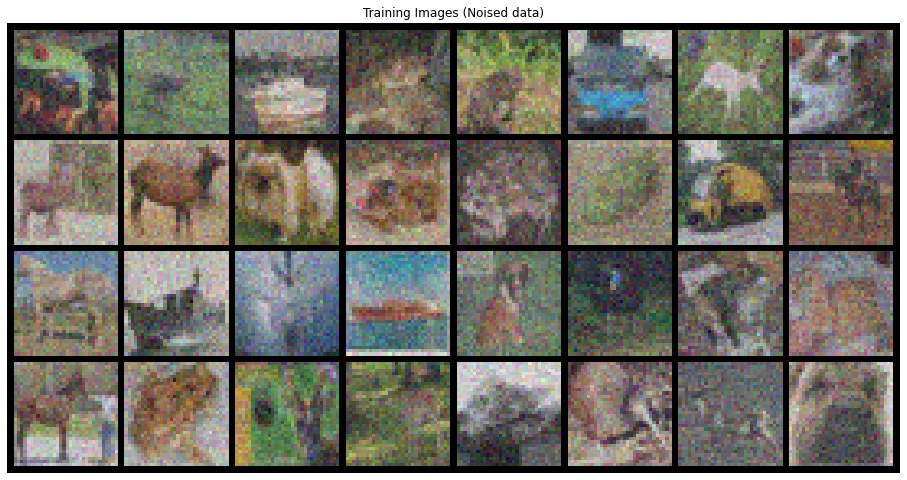

In [ ]:
# Declare dataloaders
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)
dataloader_imperfect = torch.utils.data.DataLoader(data_noise, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)
testloader_imperfect = torch.utils.data.DataLoader(testset_noise, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

# Decide the device to run program on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot grid of training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images (Original dataset)")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot grid of noised data
imperfect_batch = next(iter(dataloader_imperfect))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images (Noised data)")
plt.imshow(np.transpose(vutils.make_grid(imperfect_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization for generator and discriminator network
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# DCGAN generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply weights_init function to randomly initialize all weights
# to mean=0 and stdev=0.02
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [ ]:
# DCGAN discriminator
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # intput is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply weights_init function to randomly initialize all weights
# to mean=0 and stdev=0.2
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
# Initialize loss function, using MSE
# criterion = nn.BCELoss()
criterion = nn.MSELoss()

# Create batch of latent vectors that will be used to visualize
# progression of the generator
# fixed_noise = torch.randn(64, nz, 1, 1, device=device)
# fixed_noise = torch.randn(32, nz, 1, 1, device=device)
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
img_list_real = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Train with real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over fake and real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses to plot later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Keep track of generator's performance by saving output
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                img_list.append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))
                img_list_real.append(vutils.make_grid(real_cpu.detach().cpu(), padding=2, normalize=True))

        iters += 1

    if epoch % 1 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...
[0/10][999/1000]	Loss_D: 0.0756	Loss_G: 0.8623	D(x): 0.8577	D(G(z)): 0.1761 / 0.0734
[1/10][999/1000]	Loss_D: 0.1177	Loss_G: 0.6381	D(x): 0.7568	D(G(z)): 0.1697 / 0.2086
[2/10][999/1000]	Loss_D: 0.2187	Loss_G: 0.5584	D(x): 0.6837	D(G(z)): 0.2474 / 0.2660
[3/10][999/1000]	Loss_D: 0.3220	Loss_G: 0.6286	D(x): 0.8613	D(G(z)): 0.5059 / 0.2198
[4/10][999/1000]	Loss_D: 0.1888	Loss_G: 0.7697	D(x): 0.8422	D(G(z)): 0.3552 / 0.1254
[5/10][999/1000]	Loss_D: 0.3269	Loss_G: 0.5371	D(x): 0.5513	D(G(z)): 0.2558 / 0.2784
[6/10][999/1000]	Loss_D: 0.2283	Loss_G: 0.4916	D(x): 0.6563	D(G(z)): 0.2493 / 0.3136
[7/10][999/1000]	Loss_D: 0.3639	Loss_G: 0.7847	D(x): 0.7784	D(G(z)): 0.4809 / 0.1188
[8/10][999/1000]	Loss_D: 0.1600	Loss_G: 0.7408	D(x): 0.7340	D(G(z)): 0.2492 / 0.1424
[9/10][999/1000]	Loss_D: 0.1171	Loss_G: 0.5033	D(x): 0.7501	D(G(z)): 0.1860 / 0.3009


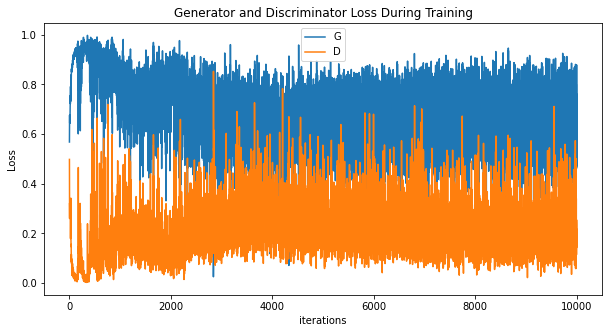

In [ ]:
# Plot of MSE loss from networks over the course of training
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

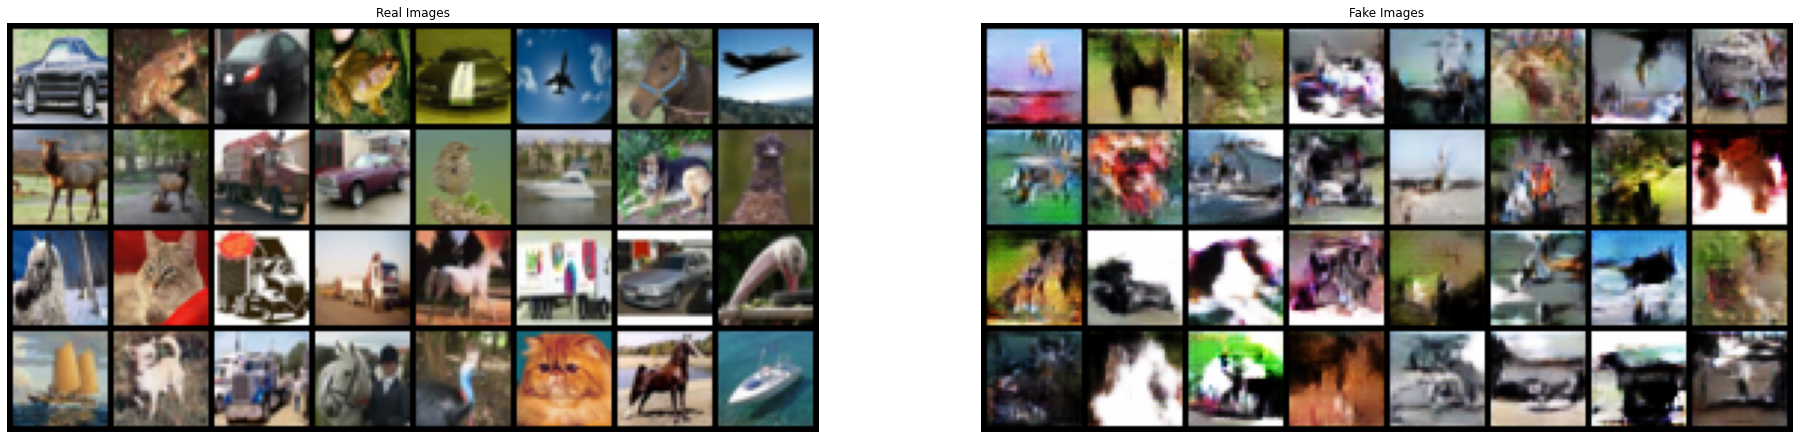

In [ ]:
# Plot real images
plt.figure(figsize=(32,32))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(img_list_real[-1],(1,2,0)))

# Plot fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Testing Loop on ground truth data
# Optimizers not utilized in testing phases as just want to assess performance and do not want to further train the network

# Lists to keep track of generated output and loss values during testing phases
img_list_test = [[] for index in range(4)]
img_list_real_test = [[] for index in range(4)]
G_losses_test = [[] for index in range(4)]
D_losses_test = [[] for index in range(4)]
iters = 0

print("Starting Testing Loop...")
# For a single pass through dataset
for epoch in range(1):
    # For each batch in the dataloader
    for i, data in enumerate(testloader, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Test with real batch
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on real batch
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # Test with fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on fake batch
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over fake and real batches
        errD = errD_real + errD_fake

        # Update G network: maximize log(D(G(z)))
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        # Save Losses to plot later
        G_losses_test[0].append(errG.item())
        D_losses_test[0].append(errD.item())

        # Keep track of generator's performance by saving output
        if(i == len(testloader)-1):
            with torch.no_grad():
                img_list_test[0].append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))
                img_list_real_test[0].append(vutils.make_grid(real_cpu.detach().cpu(), padding=2, normalize=True))

        iters += 1

    if epoch % 1 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(testloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Testing Loop...
[0/10][499/500]	Loss_D: 0.3096	Loss_G: 0.4190	D(x): 0.6629	D(G(z)): 0.3711 / 0.3711


In [ ]:
# Testing Loop on noised data

iters = 0

print("Starting Testing Loop...")
# For a single pass through dataset
for epoch in range(1):
    # For each batch in the dataloader
    for i, data in enumerate(testloader_imperfect, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Test with real batch
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on real batch
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # Test with fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the fake batch
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over fake and real batches
        errD = errD_real + errD_fake

        # Update G network: maximize log(D(G(z)))
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        # Save Losses to plot later
        G_losses_test[1].append(errG.item())
        D_losses_test[1].append(errD.item())

        # Keep track of generator's performance by saving output
        if(i == len(testloader_imperfect)-1):
            with torch.no_grad():
                img_list_test[1].append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))
                img_list_real_test[1].append(vutils.make_grid(real_cpu.detach().cpu(), padding=2, normalize=True))

        iters += 1

    if epoch % 1 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(testloader_imperfect),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Testing Loop...
[0/10][499/500]	Loss_D: 1.2427	Loss_G: 0.2985	D(x): 0.0155	D(G(z)): 0.4874 / 0.4874


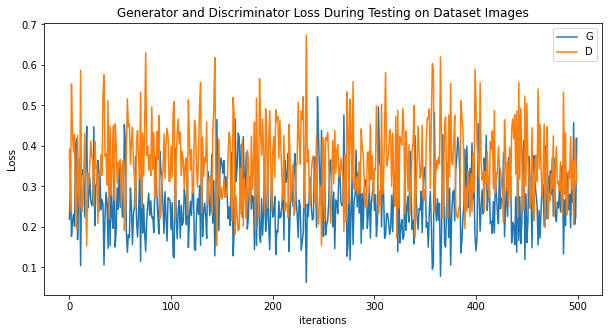

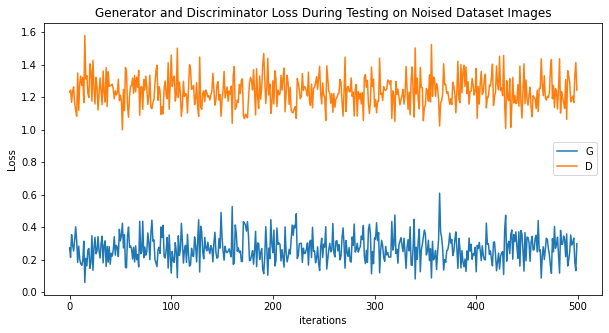

In [ ]:
# Plot of MSE loss from networks over course of testing
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Testing on Dataset Images")
plt.plot(G_losses_test[0],label="G")
plt.plot(D_losses_test[0],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Testing on Noised Dataset Images")
plt.plot(G_losses_test[1],label="G")
plt.plot(D_losses_test[1],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plot real images
plt.figure(figsize=(32,32))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(img_list_real_test[0][-1],(1,2,0)))

# Plot fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images (Test phase / Ground truth trained)")
plt.imshow(np.transpose(img_list_test[0][-1],(1,2,0)))
plt.show()

# Plot noised images
plt.figure(figsize=(32,32))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Noised images")
plt.imshow(np.transpose(img_list_real_test[1][-1],(1,2,0)))

# Plot fake noised images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Noised Images (Test phase / Ground truth trained)")
plt.imshow(np.transpose(img_list_test[1][-1],(1,2,0)))
plt.show()

In [ ]:
# Create the generator
netG2 = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG2 = nn.DataParallel(netG2, list(range(ngpu)))

# Apply weights_init function to randomly initialize all weights
# to mean=0 and stdev=0.02
netG2.apply(weights_init)

# Print the model
print(netG2)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [ ]:
# Create the discriminator
netD2 = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD2 = nn.DataParallel(netD2, list(range(ngpu)))

# Apply weights_init function to randomly initialize all weights
# to mean=0 and stdev=0.2
netD2.apply(weights_init)

# Print the model
print(netD2)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
# Setup Adam optimizers for G and D
optimizerD = optim.Adam(netD2.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG2.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list_noise = []
img_list_real_noise = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_imperfect, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Train with real batch
        netD2.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD2(real_cpu).view(-1)
        # Calculate loss on real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG2(noise)
        label.fill_(fake_label)
        # Classify fake batch with D
        output = netD2(fake.detach()).view(-1)
        # Calculate D's loss on fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over fake and real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))
        netG2.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of fake batch through D
        output = netD2(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses to plot later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Keep track of generator's performance by saving output
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_imperfect)-1)):
            with torch.no_grad():
                img_list_noise.append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))
                img_list_real_noise.append(vutils.make_grid(real_cpu.detach().cpu(), padding=2, normalize=True))

        iters += 1

    if epoch % 1 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(dataloader_imperfect),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Training Loop...
[0/10][999/1000]	Loss_D: 0.1815	Loss_G: 0.6669	D(x): 0.7383	D(G(z)): 0.2994 / 0.1865
[1/10][999/1000]	Loss_D: 0.4141	Loss_G: 0.5136	D(x): 0.5673	D(G(z)): 0.4282 / 0.2932
[2/10][999/1000]	Loss_D: 0.2990	Loss_G: 0.6543	D(x): 0.7779	D(G(z)): 0.4475 / 0.1974
[3/10][999/1000]	Loss_D: 0.3416	Loss_G: 0.6563	D(x): 0.7553	D(G(z)): 0.4862 / 0.1969
[4/10][999/1000]	Loss_D: 0.2473	Loss_G: 0.6509	D(x): 0.7602	D(G(z)): 0.3887 / 0.2000
[5/10][999/1000]	Loss_D: 0.3309	Loss_G: 0.4116	D(x): 0.5326	D(G(z)): 0.2605 / 0.3718
[6/10][999/1000]	Loss_D: 0.3462	Loss_G: 0.4964	D(x): 0.5488	D(G(z)): 0.3217 / 0.3029
[7/10][999/1000]	Loss_D: 0.3375	Loss_G: 0.5262	D(x): 0.6183	D(G(z)): 0.3544 / 0.2884
[8/10][999/1000]	Loss_D: 0.3512	Loss_G: 0.5315	D(x): 0.5145	D(G(z)): 0.2643 / 0.2828
[9/10][999/1000]	Loss_D: 0.3785	Loss_G: 0.4676	D(x): 0.5810	D(G(z)): 0.3856 / 0.3371


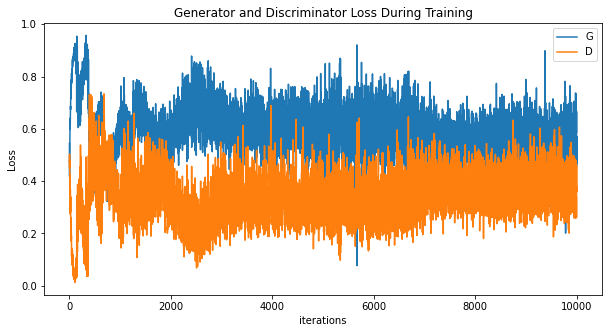

In [ ]:
# Plot of MSE loss from networks over the course of training
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

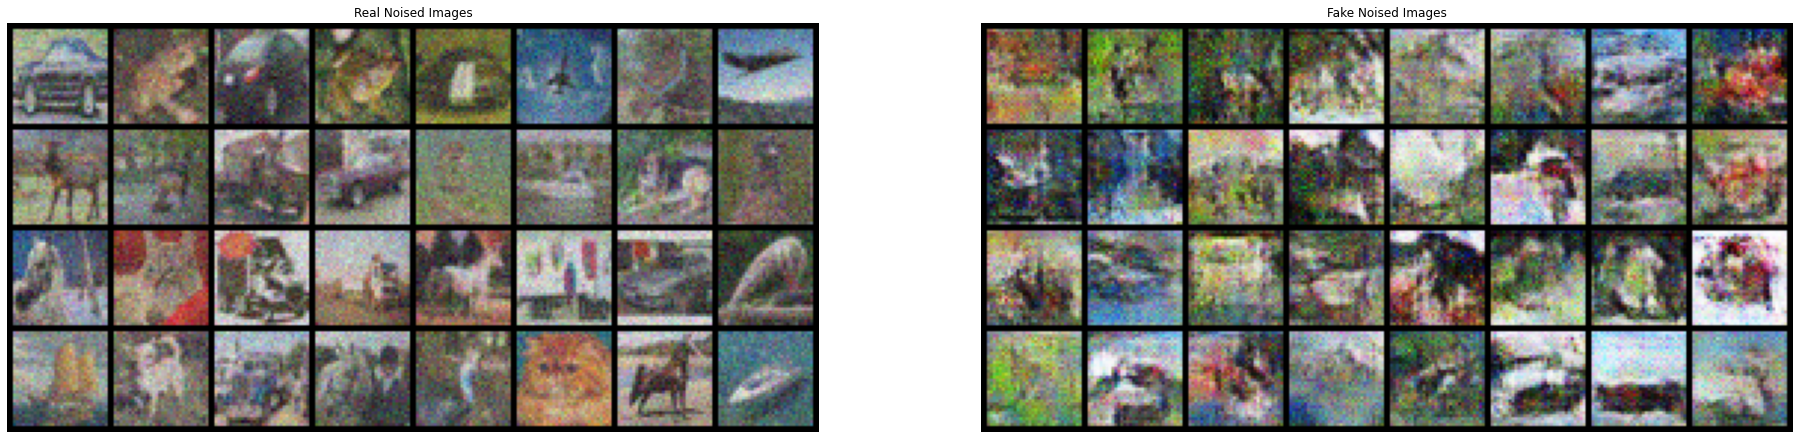

In [ ]:
# Plot real images
plt.figure(figsize=(32,32))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Noised Images")
plt.imshow(np.transpose(img_list_real_noise[-1],(1,2,0)))

# Plot fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Noised Images")
plt.imshow(np.transpose(img_list_noise[-1],(1,2,0)))
plt.show()

In [ ]:
# Testing Loop on noised data

iters = 0

print("Starting Testing Loop...")
# For a single pass through dataset
for epoch in range(1):
    # For each batch in the dataloader
    for i, data in enumerate(testloader_imperfect, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Test with real batch
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD2(real_cpu).view(-1)
        # Calculate loss on real batch
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # Test with fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG2(noise)
        label.fill_(fake_label)
        # Classify fake batch with D
        output = netD2(fake.detach()).view(-1)
        # Calculate D's loss on fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over fake and real batches
        errD = errD_real + errD_fake

        # Update G network: maximize log(D(G(z)))
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of fake batch through D
        output = netD2(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        D_G_z2 = output.mean().item()

        # Save Losses to plot later
        G_losses_test[2].append(errG.item())
        D_losses_test[2].append(errD.item())

        # Keep track of generator's performance by saving output
        if(i == len(testloader_imperfect)-1):
            with torch.no_grad():
                img_list_test[2].append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))
                img_list_real_test[2].append(vutils.make_grid(real_cpu.detach().cpu(), padding=2, normalize=True))

        iters += 1

    if epoch % 1 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(testloader_imperfect),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Testing Loop...
[0/10][499/500]	Loss_D: 0.3268	Loss_G: 0.3932	D(x): 0.6410	D(G(z)): 0.3917 / 0.3917


In [ ]:
# Testing Loop on ground truth data

iters = 0

print("Starting Testing Loop...")
# For a single pass through dataset
for epoch in range(1):
    # For each batch in the dataloader
    for i, data in enumerate(testloader, 0):

        # Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Test with real batch
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD2(real_cpu).view(-1)
        # Calculate loss on real batch
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # Test with fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG2(noise)
        label.fill_(fake_label)
        # Classify fake batch with D
        output = netD2(fake.detach()).view(-1)
        # Calculate D's loss on the fake batch
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over fake and real batches
        errD = errD_real + errD_fake

        # Update G network: maximize log(D(G(z)))
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD2(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        # Save Losses to plot later
        G_losses_test[3].append(errG.item())
        D_losses_test[3].append(errD.item())

        # Keep track of generator's performance by saving output
        if(i == len(testloader)-1):
            with torch.no_grad():
                img_list_test[3].append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))
                img_list_real_test[3].append(vutils.make_grid(real_cpu.detach().cpu(), padding=2, normalize=True))

        iters += 1

    if epoch % 1 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(testloader_imperfect),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

Starting Testing Loop...
[0/10][499/500]	Loss_D: 0.3612	Loss_G: 0.3502	D(x): 0.6681	D(G(z)): 0.4382 / 0.4382


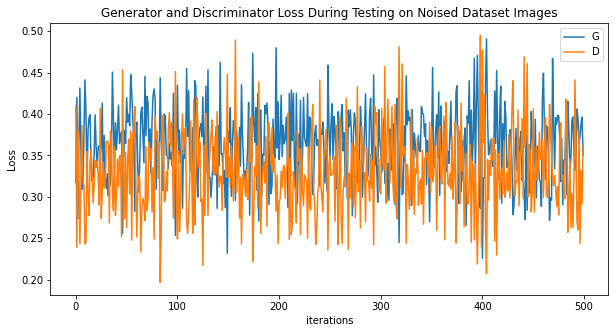

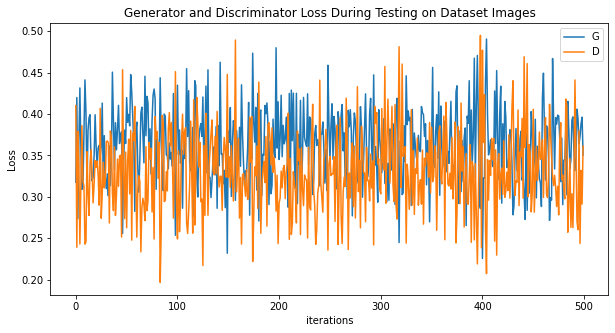

In [ ]:
# Plot of MSE loss from networks over the course of noised set testing
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Testing on Noised Dataset Images")
plt.plot(G_losses_test[3],label="G")
plt.plot(D_losses_test[3],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Testing on Dataset Images")
plt.plot(G_losses_test[3],label="G")
plt.plot(D_losses_test[3],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Plot noised images
plt.figure(figsize=(32,32))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Noised images")
plt.imshow(np.transpose(img_list_real_test[2][-1],(1,2,0)))

# Plot fake noised images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Noised Images (Test phase / Noise trained)")
plt.imshow(np.transpose(img_list_test[2][-1],(1,2,0)))
plt.show()

# Plot real images
plt.figure(figsize=(32,32))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(img_list_real_test[3][-1],(1,2,0)))

# Plot fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images (Test phase / Noise trained)")
plt.imshow(np.transpose(img_list_test[3][-1],(1,2,0)))
plt.show()

In [ ]:
# Overall comparison of GAN testing after training with complete samples vs. partial/noisy samples

plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(img_list_real[-1],(1,2,0)))

# Plot fake images from the last epoch
plt.figure(figsize=(12,8))
plt.axis("off")
plt.title("Fake Images (Test phase / Ground truth trained)")
plt.imshow(np.transpose(img_list_test[0][-1],(1,2,0)))
plt.show()

# Plot fake images from the last epoch
plt.figure(figsize=(12,8))
plt.axis("off")
plt.title("Fake Images (Test phase / Noise trained)")
plt.imshow(np.transpose(img_list_test[3][-1],(1,2,0)))
plt.show()

# Plot of MSE loss from networks over the course noised set testing
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss (Ground truth trained) During Testing on Dataset Images")
plt.plot(G_losses_test[0],label="G")
plt.plot(D_losses_test[0],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss (Noised data trained) During Testing on Dataset Images")
plt.plot(G_losses_test[3],label="G")
plt.plot(D_losses_test[3],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Noised Images")
plt.imshow(np.transpose(img_list_real_noise[-1],(1,2,0)))

# Plot fake images from the last epoch
plt.figure(figsize=(12,8))
plt.axis("off")
plt.title("Fake Noised Images (Test phase / Ground truth trained)")
plt.imshow(np.transpose(img_list_test[1][-1],(1,2,0)))
plt.show()

# Plot fake images from the last epoch
plt.figure(figsize=(12,8))
plt.axis("off")
plt.title("Fake Noised Images (Test phase / Noise trained)")
plt.imshow(np.transpose(img_list_test[2][-1],(1,2,0)))
plt.show()

# Plot of MSE loss from networks over the course of noised set testing
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss (Ground truth trained) During Testing on Noised Dataset Images")
plt.plot(G_losses_test[1],label="G")
plt.plot(D_losses_test[1],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss (Noised data trained) During Testing on Noised Dataset Images")
plt.plot(G_losses_test[2],label="G")
plt.plot(D_losses_test[2],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()